In [7]:
import re
import nltk
from transformers import pipeline
from nltk.corpus import stopwords
import pandas as pd
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
comments_df = pd.read_csv("youtube_comments.csv")  
tweets_df = pd.read_csv("tweets.csv")             
comments_df['source'] = 'youtube'
tweets_df['source'] = 'twitter'
combined_df = pd.concat([comments_df, tweets_df], ignore_index=True)


In [3]:
print(combined_df.columns)

Index(['text', 'source'], dtype='object')


In [4]:
print(combined_df.columns)

Index(['text', 'source'], dtype='object')


In [5]:
from tqdm import tqdm
from langdetect import detect

tqdm.pandas()

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

combined_df['language'] = combined_df['text'].progress_apply(detect_language)


100%|██████████████████████████████████████████████████████████████████████████████| 3376/3376 [00:45<00:00, 73.73it/s]


In [8]:
# Sentiment pipeline (Multilingual)
classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--nlptown--bert-base-multilingual-uncased-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [9]:
# Multilingual model outputs labels like: 1 star, 2 stars, ..., 5 stars
# We'll convert those to POSITIVE, NEGATIVE, NEUTRAL

def classify_sentiment(text):
    try:
        result = classifier(str(text[:512]))[0]
        label = result['label']
        score = result['score']

        # Normalize to POSITIVE / NEGATIVE / NEUTRAL
        if label in ['4 stars', '5 stars']:
            sentiment = 'POSITIVE'
        elif label in ['1 star', '2 stars']:
            sentiment = 'NEGATIVE'
        else:
            sentiment = 'NEUTRAL'

        return {
            "sentiment_label": sentiment,
            "sentiment_score": score
        }

    except:
        return {
            "sentiment_label": "ERROR",
            "sentiment_score": 0.0
        }


In [10]:
# Apply sentiment classification
sentiment_data = combined_df["text"].apply(classify_sentiment)
combined_df["sentiment_label"] = sentiment_data.apply(lambda x: x["sentiment_label"])
combined_df["sentiment_score"] = sentiment_data.apply(lambda x: x["sentiment_score"])

In [12]:
print(combined_df[['text', 'sentiment_label']].head())

                                                text sentiment_label
0  Shubhankar Mishra WhatsApp से जुड़कर हमारी ताक...        POSITIVE
1  इस टाइम हम सबको भारत के जवानों का हौसला बढ़ाना...        POSITIVE
2  Mere 20 saal ka bhai Indian army mein hai. \nB...        POSITIVE
3  ऑपरेशन सिंदूर नाम ही सुनकर ही सुकून आ रहा है \...        POSITIVE
4  In my family 2 brother is in army n 1brother i...        POSITIVE


In [13]:
combined_df.to_csv("labeled_sentiment_output.csv", index=False)

In [14]:
combined_df['sentiment_label'].value_counts()

sentiment_label
NEGATIVE    1618
POSITIVE    1403
NEUTRAL      355
Name: count, dtype: int64

In [15]:
# Average sentiment score per label
print(combined_df.groupby('sentiment_label')['sentiment_score'].mean())


sentiment_label
NEGATIVE    0.427105
NEUTRAL     0.266171
POSITIVE    0.422909
Name: sentiment_score, dtype: float64


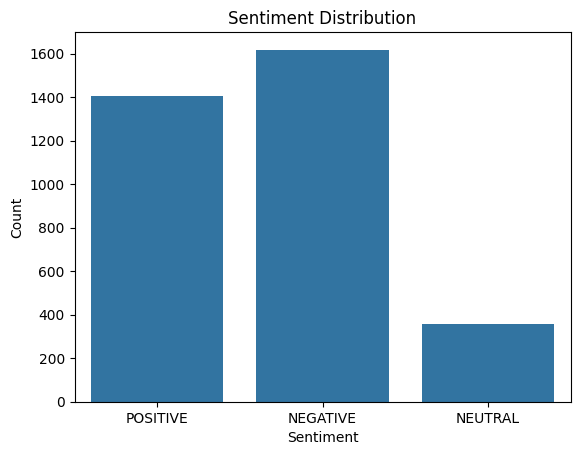

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=combined_df, x='sentiment_label')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

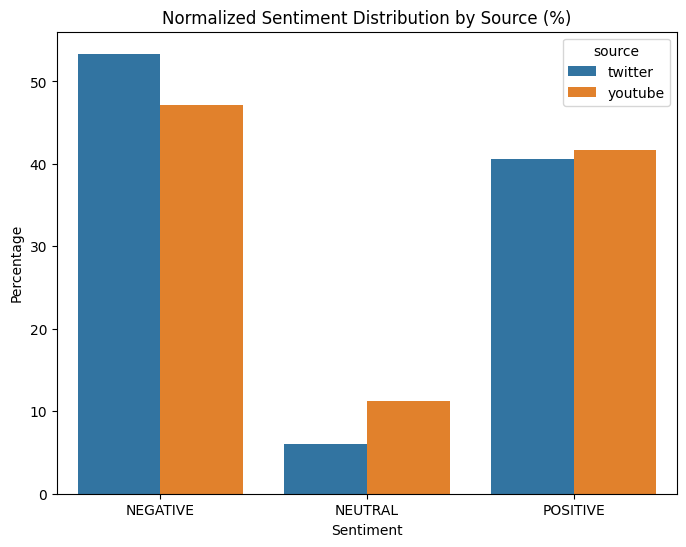

In [18]:
# 📊 Normalized sentiment percentages by source
# Group and calculate percentage
count_df = combined_df.groupby(['source', 'sentiment_label']).size().reset_index(name='count')
total_per_source = count_df.groupby('source')['count'].transform('sum')
count_df['percentage'] = 100 * count_df['count'] / total_per_source

# Plot normalized distribution
plt.figure(figsize=(8, 6))
sns.barplot(data=count_df, x='sentiment_label', y='percentage', hue='source')
plt.title("Normalized Sentiment Distribution by Source (%)")
plt.xlabel("Sentiment")
plt.ylabel("Percentage")
plt.show()